# Graph GP Classification

## Preamble
This notebook provides an example of Gaussian process classification on a graph using Graph Matern kernel and non-conjugate learning techiques described in the paper.

In [1]:
#import os 
#os.chdir (r"C:\Users\Iskander\PycharmProjects\Graph-Gaussian-Processes")
#%pwd

In [2]:
import networkx as nx, numpy as np
import pickle, gpflow, warn, os.path, os
import tensorflow as tf
from tqdm.notebook import trange
from examples.utils.preprocessing import load_cora
from graph_matern.kernels.graph_matern_kernel import GraphMaternKernel
from graph_matern.inducing_variables import GPInducingVariables
from graph_matern.svgp import GraphSVGP
from scipy import sparse

C:\Users\Iskander\anaconda3\envs\graph_kernel\lib\site-packages\gpflow\experimental\utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.decorator.check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(
C:\Users\Iskander\anaconda3\envs\graph_kernel\lib\site-packages\gpflow\experimental\utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.inheritance.inherit_check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(


In [3]:
dtype = tf.float64
gpflow.config.set_default_float(dtype)
gpflow.config.set_default_summary_fmt("notebook")
tf.get_logger().setLevel('ERROR')

## Load and preprocess the Cora dataset
The nasty details of the dataset preparation are hidden away in `preprocessing` module.

In [4]:
np.random.seed(123)
num_eigenpairs = 500
dataset = 'cora'
cls_number = 7
train_num = 140

In [5]:
G, data_train, data_test = load_cora(num_train=train_num, num_test=1000)
x_train, y_train = data_train
x_test, y_test = data_test

##  Compute Laplacian eigenpairs

In [6]:
eigenpairs_path = "eigenpairs_{}.pkl".format(dataset)
if not os.path.isfile(eigenpairs_path):
    laplacian = sparse.csr_matrix(nx.laplacian_matrix(G), dtype=np.float64)
    if num_eigenpairs >= len(G):
        warn.warn("Number of features is greater than number of vertices. Number of features will be reduced.")
        num_eigenpairs = len(G)

    eigenvalues, eigenvectors = tf.linalg.eigh(laplacian.toarray())
    eigenvectors, eigenvalues = eigenvectors[:, :num_eigenpairs], eigenvalues[:num_eigenpairs]

    with open(eigenpairs_path, "wb") as f:
        pickle.dump((eigenvectors[:, :num_eigenpairs].numpy(), eigenvalues.numpy()), f)

with open(eigenpairs_path, "rb") as f:
    eigenvectors, eigenvalues = pickle.load(f)
eigenvalues, eigenvectors = tf.convert_to_tensor(eigenvalues, dtype=dtype), tf.convert_to_tensor(eigenvectors, dtype)

## Build a GP model
Here we employ techiques of non-conjugate learning described in the section 3.1 of the paper.

Briefly, we approximate a non-Gaussian posterior with a variational distribution induced by _inducing_ points on the graph.
We choose the inducing points to be all training points.

The model is then the usual `SVGP`.

In [7]:
inducing_points = GPInducingVariables(x_train, cls_number)
kernel = GraphMaternKernel((eigenvectors, eigenvalues), nu=3/2, kappa=5, sigma_f=1.0, vertex_dim=0, point_kernel=None, dtype=dtype)
# To use the diffusion kernel uncomment the following string
# kernel = GraphDiffusionKernel((eigenvectors, eigenvalues), kappa=5, sigma_f=1.0, vertex_dim=0, point_kernel=point_kernel, dtype=dtype)

ListWrapper([140, 1])


In [8]:
def opt_step(opt, loss, variables):
    opt.minimize(loss, var_list=variables)

def optimize_SVGP(model, optimizers, steps, q_diag=True):
    if not q_diag:
        gpflow.set_trainable(model.q_mu, False)
        gpflow.set_trainable(model.q_sqrt, False)

    adam_opt, natgrad_opt = optimizers

    variational_params = [(model.q_mu, model.q_sqrt)]

    autotune = tf.data.experimental.AUTOTUNE
    data_minibatch = (
        tf.data.Dataset.from_tensor_slices(data_train)
            .prefetch(autotune)
            .repeat()
            .shuffle(train_num)
            .batch(train_num)
    )
    data_minibatch_it = iter(data_minibatch)
    loss = model.training_loss_closure(data_minibatch_it)
    adam_params = model.trainable_variables
    natgrad_params = variational_params

    adam_opt.minimize(loss, var_list=adam_params)
    if not q_diag:
        natgrad_opt.minimize(loss, var_list=natgrad_params)
    t = trange(steps)
    for step in t:
        opt_step(adam_opt, loss, adam_params)
        if not q_diag:
            opt_step(natgrad_opt, loss, natgrad_params)
        if step % 200 == 0:
            likelihood = model.elbo(data_train)
            t.set_postfix({'ELBO': likelihood.numpy()})

In [17]:
# To use GraphSVGP change the strings with comments.
model = gpflow.models.SVGP( # model = GraphSVGP(
    kernel=kernel,
    likelihood=gpflow.likelihoods.MultiClass(cls_number),
    inducing_variable=inducing_points, #inducing_variable=[0]*num_eigenpairs,
    num_latent_gps=cls_number,
    whiten=True,
    q_diag=True,
)
adam_opt = tf.optimizers.Adam(0.001)
natgrad_opt = gpflow.optimizers.NaturalGradient(gamma=0.001)

optimize_SVGP(model, (adam_opt, natgrad_opt), 1000, True)
gpflow.utilities.print_summary(model)

  0%|          | 0/1000 [00:00<?, ?it/s]

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.nu,Parameter,Softplus,,True,(),float64,5.02552
SVGP.kernel.kappa,Parameter,Softplus,,True,(),float64,4.87604
SVGP.kernel.sigma_f,Parameter,Softplus,,True,(),float64,16.7817
SVGP.likelihood.invlink.epsilon,Parameter,Sigmoid,Beta,False,(),float64,0.001
SVGP.inducing_variable.x_v,Parameter,Identity,,True,"(140, 0)",float64,[]
SVGP.q_mu,Parameter,Identity,,True,"(140, 7)",float64,"[[-0.83583, -0.53596, 0.93255..."
SVGP.q_sqrt,Parameter,Softplus,,True,"(140, 7)",float64,"[[0.58225, 0.53098, 0.77739..."


## Test the model


In [18]:
y_pred_mean, y_pred_var = model.predict_y(x_test)
y_pred = np.argmax(y_pred_mean.numpy(), axis=1).ravel()
accuracy = np.count_nonzero((y_pred - y_test.ravel()) == 0) / y_pred.size
print('Accuracy is {}'.format(accuracy))

Accuracy is 0.787


The pictures in the paper are made with `yEd`.
Further code cell saves simulation results in a `yEd` readable format.

In [12]:
nodes = np.arange(len(G), dtype=np.float64).reshape(-1, 1)

prediction, _ = model.predict_y(nodes)
prediction = np.argmax(prediction.numpy(), axis=1).ravel()
prediction = {int(nodes[i][0]): prediction[i] for i in range(len(G))}

nx.set_node_attributes(G, values=prediction, name='prediction')
nx.readwrite.write_graphml(G, 'data/cora/cora_result.graphml')

These are the pictures processed with `yEd`:

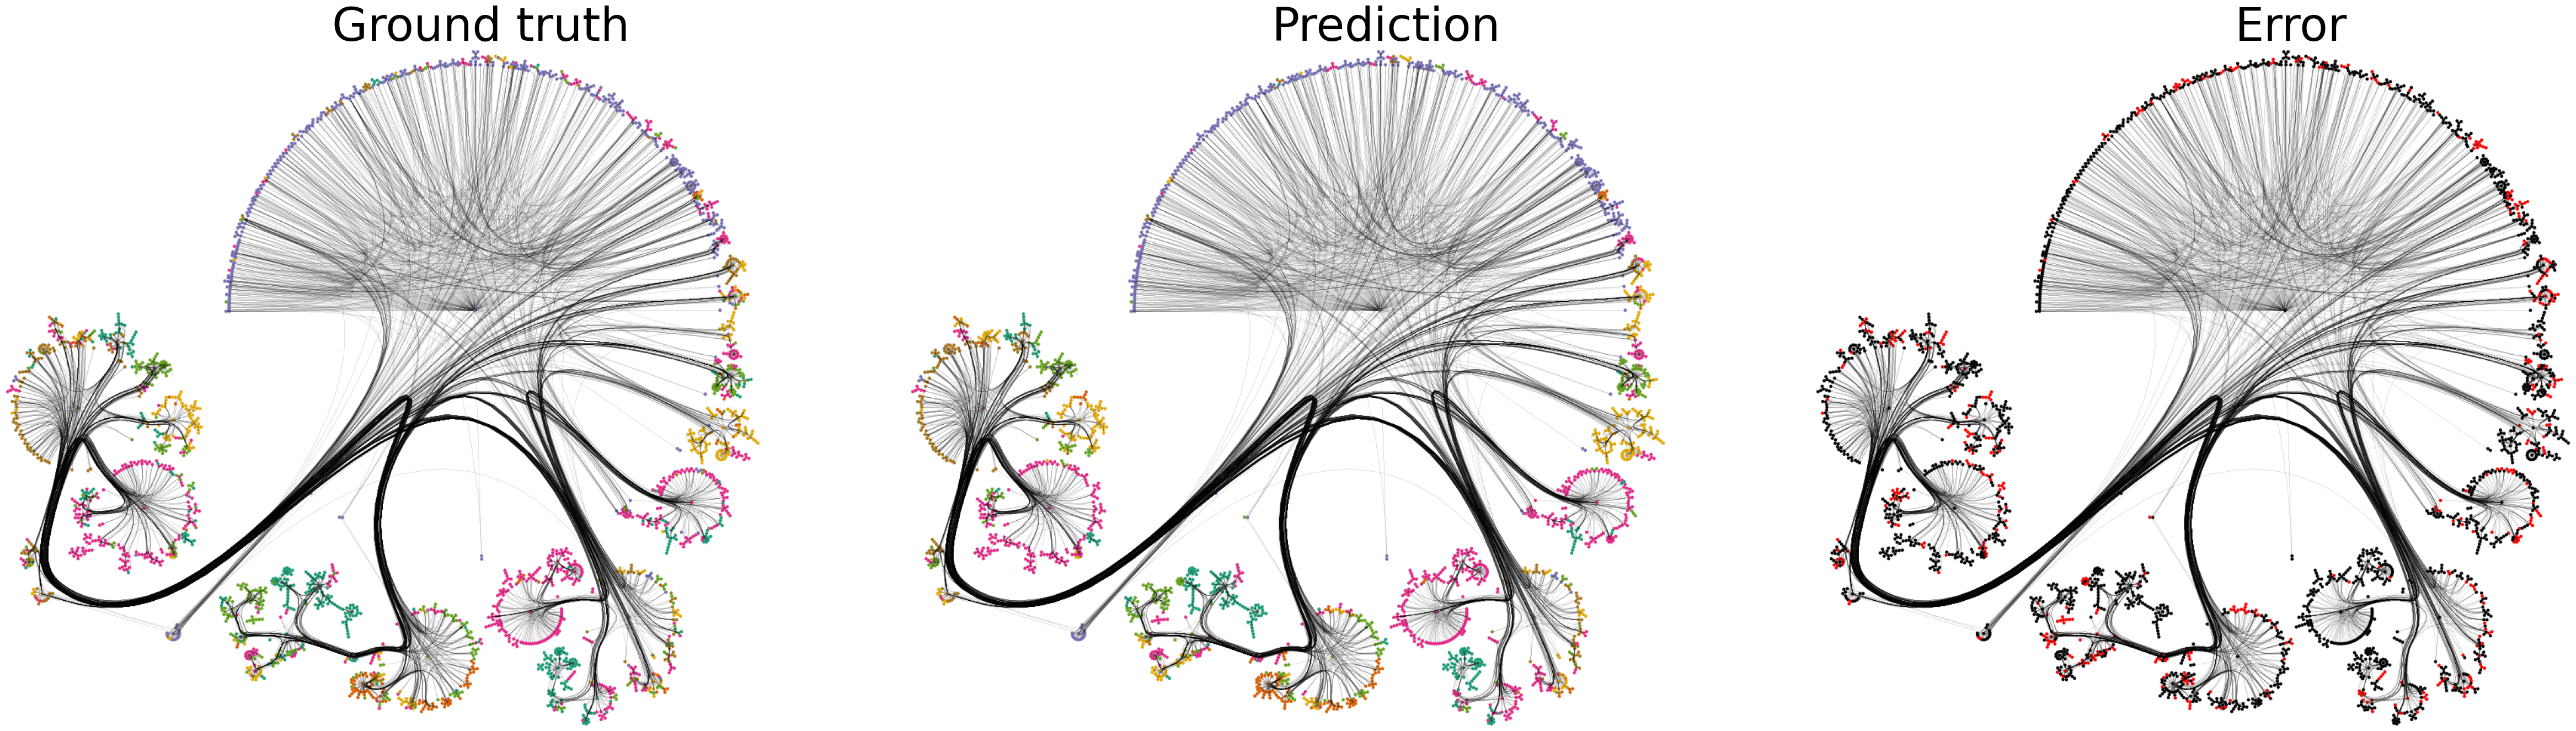

In [13]:
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms

img_paths = ('pictures/G_true_dark2.png', 'pictures/G_pred_dark2.png', 'pictures/G_errors.png')
titles = ('Ground truth', 'Prediction', 'Error')

img_size = 20
plt.figure(figsize=(img_size*len(img_paths), img_size*1))

for i, (img_path, title) in enumerate(zip(img_paths, titles)):
    ax = plt.subplot(1, 3, i+1)
    img = plt.imread(img_path) 
    plt.axis('off')
    plt.imshow(img) 
    center_x = 0.63  # 0.63 is apparently the center of the jellyfish
    text = plt.title(title, fontsize=img_size*3, x=center_x)  